In [1]:
import os,sys
import numpy as np
import scipy.stats as st
from scripts.BA_C import BA
import math
import random as rand
import matplotlib.pyplot as plt
import glob
import pandas as pd
import scipy.stats as st
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

In [2]:
def get_subsample_data(this_data,df):
    sub_data = np.zeros(shape=(int(this_data.shape[0]/df),this_data.shape[1]))
    
    for i in range(0,this_data.shape[1]):
        sub_data[:,i] = rand.choices(this_data[:,i],k=sub_data.shape[0])
        
    return sub_data

In [3]:
data_directory = './Example_data/'
translation_power = 10.0
data_directory += str(translation_power).replace('.','-')+'_samples'
os.chdir(data_directory)

data_fractions = [1,2,5,10]
reps = 5

c_files = glob.glob('T*.csv')
print(c_files)

['T1_0.csv', 'T1000_0.csv', 'T10_0.csv', 'T5_0.csv', 'T100_0.csv', 'T2500_0.csv', 'T2_5.csv', 'T50_0.csv', 'T250_0.csv', 'T25_0.csv', 'T500_0.csv']


In [4]:
t_values = []
datas = {}
diss_datas = {}

for f in c_files:
    t = f.replace('T','').replace('.csv','').replace('_','.')

    datas[t] = pd.read_csv(f,header=None).to_numpy()
    
    t_values.append(float(t))

t_values.sort()

t_and_c = np.zeros(shape=(len(t_values),2))
t_and_c[:,0] = np.array(t_values)
print(t_and_c[:,0])

[1.0e+00 2.5e+00 5.0e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02 2.5e+02 5.0e+02
 1.0e+03 2.5e+03]


In [5]:
max_bins = 32

bao = BA()

cs = []

for i in range(0,t_and_c.shape[0]):
    d = str(t_and_c[i,0])
    
    gmin, gmax = np.min(datas[d]),np.max(datas[d])
    
    if t_and_c[i,0]<10.0:
        bins = max_bins/8
    elif t_and_c[i,0]<100.0:
        bins = max_bins/4
    elif t_and_c[i,0]<1000.0:
        bins = max_bins/2
 
    bin_size = int(min(bins,int(gmax - gmin + 1)))
            
    g_edges = np.linspace(gmin,gmax,bin_size+1)
    
    this_c_set = np.zeros(shape=(len(data_fractions)*5,5))
    
    k = 0
    
    for df in data_fractions:
        for r in range(0,reps):
            sub_data = get_subsample_data(datas[d],df)
            
            g_pdfs = np.zeros(shape=(datas[d].shape[1],bin_size))

            for j in range(0,datas[d].shape[1]):
                ghist, bin_edges = np.histogram(sub_data[:,j],bins=g_edges)

                g_pdfs[j,:] = ghist/np.sum(ghist)
    
            bao.set_response(g_pdfs)
            c, e, p = bao.get_CC()
            
            this_c_set[k,0] = df
            this_c_set[k,1] = c
            
            k += 1
            
    res = st.linregress(this_c_set[:,0],this_c_set[:,1])
    
    c = float("{:.2f}".format(res.intercept))
    
    t_and_c[i,1] = c
    
    print(d,c)
    
sorted_t_and_c = t_and_c[tuple([np.argsort(t_and_c[:,0])])]

1.0 0.09
2.5 0.16
5.0 0.18
10.0 0.7
25.0 0.9
50.0 0.98
100.0 1.1
250.0 1.15
500.0 1.19
1000.0 1.24
2500.0 1.41


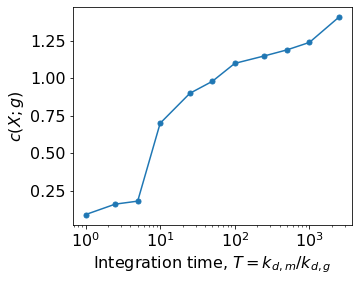

In [6]:
outfile = 'C-summary'+str(translation_power).replace('.','-')+'.csv'

np.savetxt(outfile,sorted_t_and_c,delimiter=',',header='T,c_g,sigma',comments='')

fig = plt.figure(figsize=(5,4))

plt.plot(t_and_c[:,0],t_and_c[:,1],marker='.',ms=10)
plt.xscale('log')
plt.xlabel(r'Integration time, $T=k_{d,m}/k_{d,g}$',size=16)
plt.ylabel(r'$c(X;g)$',size=16)
plt.tick_params(labelsize=16)